# Libraries Necessary 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from scipy import stats
import scipy as sp
import math
import random
from scipy.optimize import curve_fit,minimize
from numpy.linalg import inv
from tqdm import tqdm as tqdm

In [2]:
# Import Relavant Modules 

from LifetimeAnalysis.LifetimeAnalysis import Run

# Summary of November 2020 Production Run 


* ELOG Summary of Runs: https://maxwell.npl.washington.edu/elog/CENPA/Ne-19/14

**General Info for Runs:**

* Date: 11/24/2020
* Runs are named: runTEST11242020_#
* Channel and Trigger Configuration:
    * Ch0 = analog signal from the scintillator far from the decay volume (A)
    * Ch1 = analog signal from the scintillator near to the decay volume (B)
    * Both Ch0 and Ch1 were controlled by the external trigger (TRIG IN on front of digitizer) with no self-trigger (no threshold on the channels themselves). The external trigger was the A-B Coincidence NIM signal from the electronics.
    * Ch2 corresponds to t=0 which indicates the roughing valve CLOSING and that the Beam turned ON 20s prior (in general). This is NIM.
    * Ch2 triggered independently from the external trigger.
    * These settings were implemented with the frewrites file FreeWrites_PSD_ch0-ch1EXT_ch2Free.txt


**General Info for this Document:**

* Plots all have 1 second bins. 
* Orange vertical lines represent the BEAM turning ON (20s prior to trigger from ch2). 

# Run Plots: 

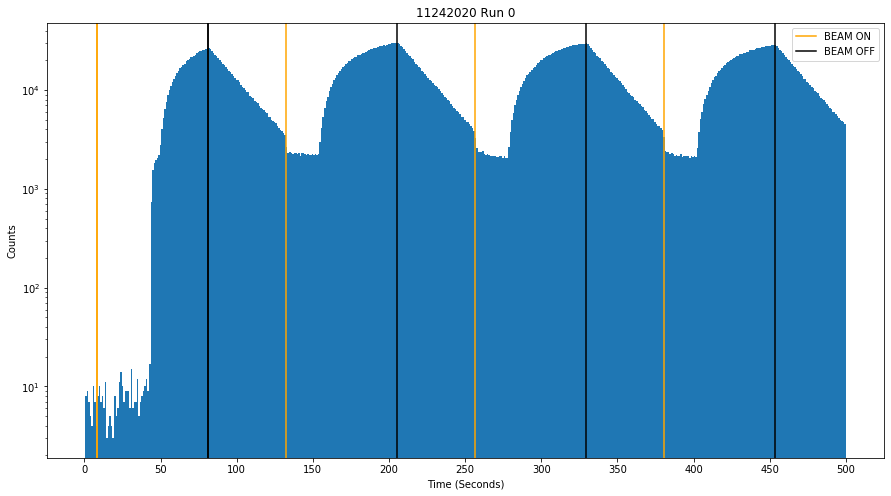

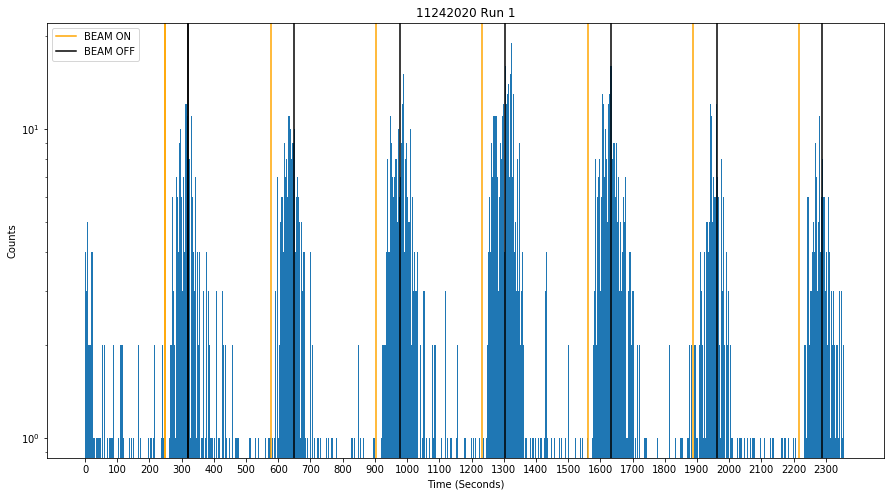

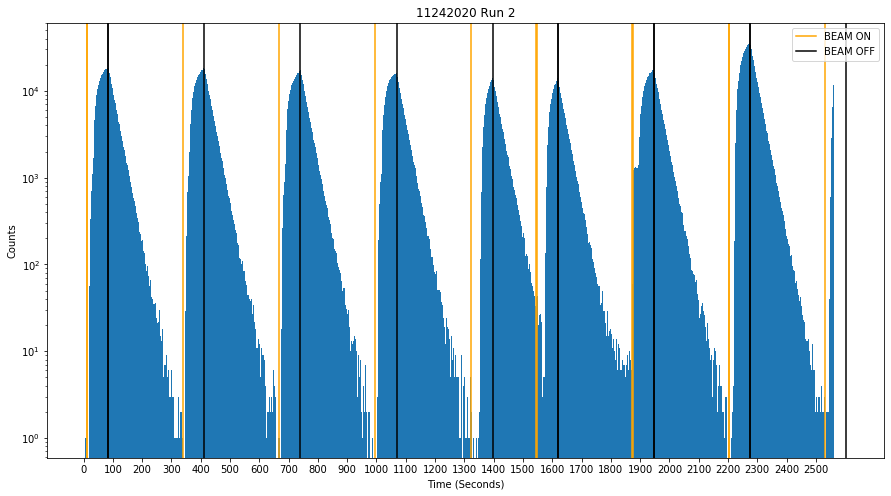

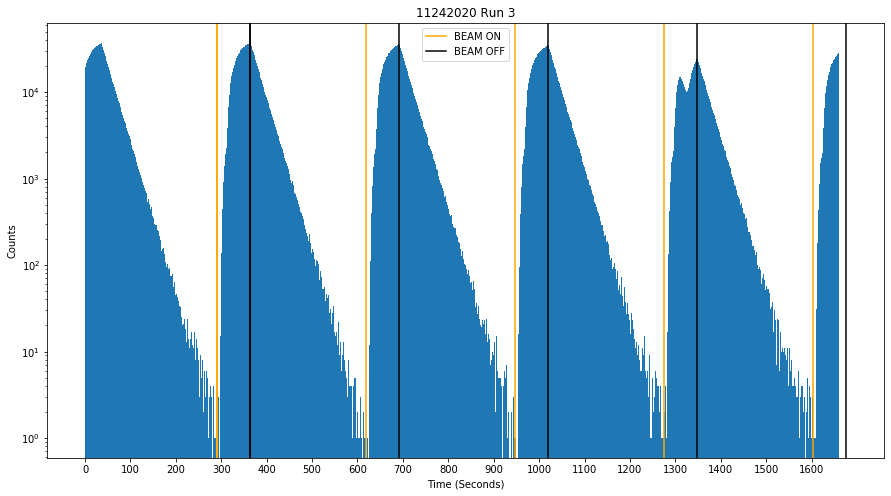

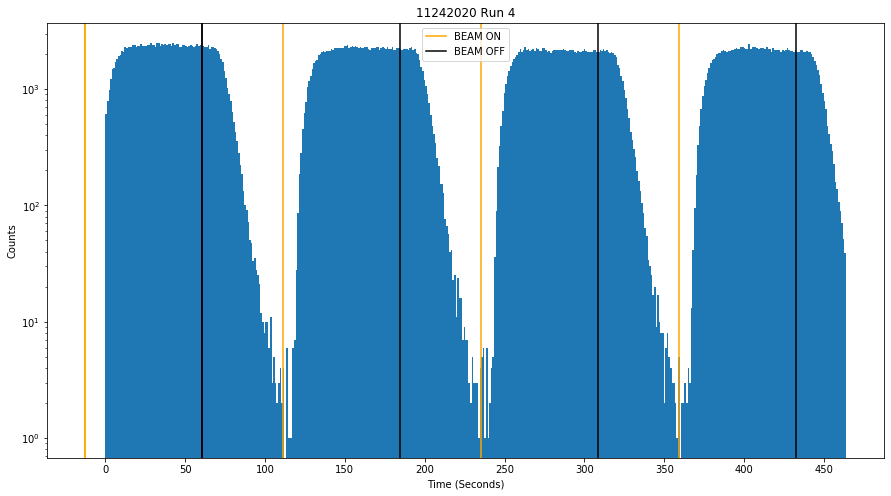

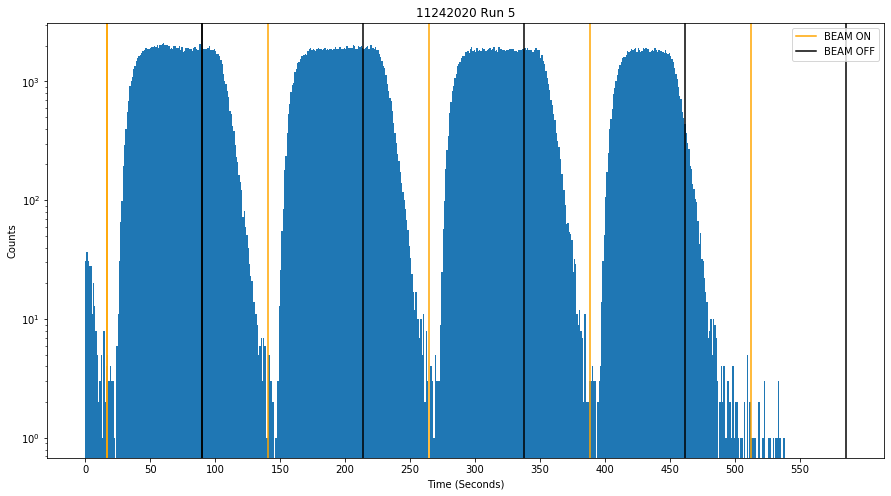

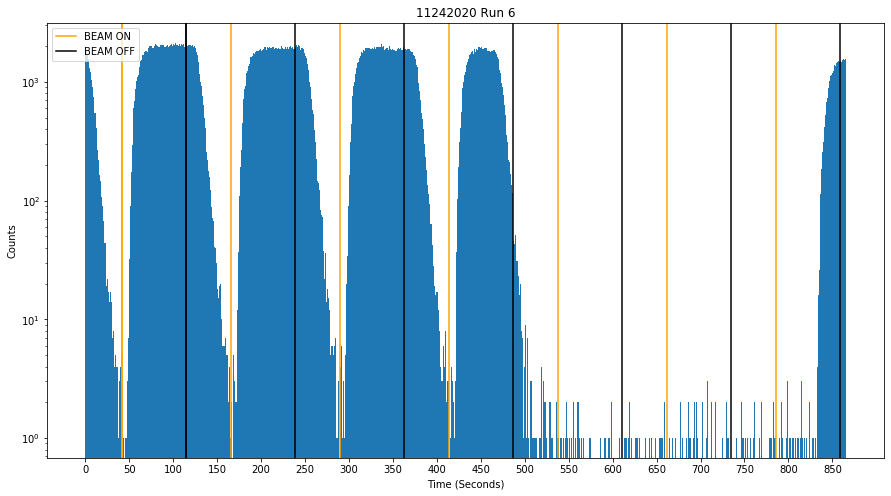

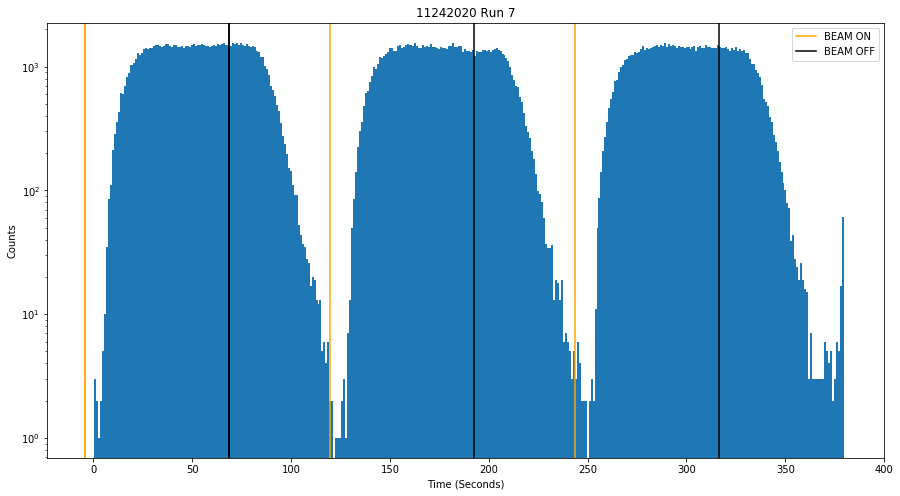

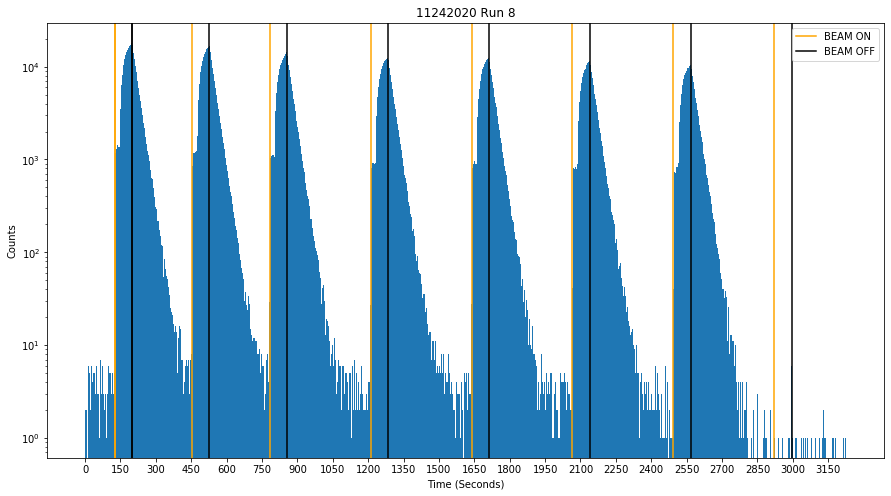

In [3]:
for i in range(9):
    
    RunNumber = Run(Date = '11242020', Run = i)
    
    BinNum = int(RunNumber.Data[0]['TIMETAG'].max()*10**-12) # Setting the number of bins = time of run in seconds.
    ax = plt.figure(figsize=(15,8))
    plt.tight_layout()
    plt.title('11242020 Run {}'.format(i))
    plt.ylabel('Counts')
    plt.xlabel('Time (Seconds)')
    plt.yscale('log')

    xcoords0 = (RunNumber.Data[2]['TIMETAG']*10**-12 -20) # Changing this to reflect BEAM ON. 
    plt.axvline(x=xcoords0[0],color='orange', label = 'BEAM ON') # Beam  Start
    plt.axvline(x=xcoords0[0] + 73, color = 'black', label = 'BEAM OFF') 
    for xc0 in xcoords0:
        plt.axvline(x=xc0,color='orange') # Beam  Start
        plt.axvline(x=xc0 + 73, color = 'black') # Cycle Stop
        
    y, x, _ = plt.hist(RunNumber.Data[0]['TIMETAG']*10**-12,bins=BinNum);

    tickfactor = 50
    tick_spacing = np.around((max(x)-min(x))/(40*tickfactor))*tickfactor+tickfactor

    plt.xticks(np.arange(np.around((min(x)/tickfactor))*tickfactor, np.around((max(x)/tickfactor))*tickfactor+1, tick_spacing))
    plt.legend()
#     plt.savefig('Plots/11242020_Run{}'.format(i))
    plt.show()
    
    

# General Tasks: 

1. Use the above tests to figure out the optimal cycle structure and total number of cycles for a competitive measurement. We want to: 
    * Optimize initial rate.
    * Minimize background and eliminate time-varying background.
    * Have a long enough cycle that we "collide" with background.
    * Have enough cycles and total counts that we have the statistics we need. This may take some simulating.
2. Create my own object oriented analysis script.
    * Allow for both ch0 and ch1 data to be read in at once. 
    * Use it to investigate the dead-time in the above tests. 
    * Use it to simulate the amount of data we need to get a certain uncertainty in the lifetime. 
    


# Task 1: Optimizing the Cycle Structure 

Use the above tests to figure out the optimal cycle structure. We want to: 

1. Optimize initial rate.
    * Accumumate for an extra ~10s. Based on the slopes when accum valve closes. (May be negated by wanting to minimize background.)
2. Minimize background and eliminate time-varying background.
    * With the current shielding we need to wait roughly 50s until the background is constant and low. 
    * The accum valve is opened roughly 15s before the background rises due to the beam being turned on. 
        * Note that we find the beam reaches the accum valve in roughly 6s, though initially the rate is so little it presumably doesn't effect the background. 
3. Have a long enough cycle that we "collide" with background.
    * We certainly collided with the background in Run 8. 
4. Use what we learned from the TOF tests. 
    * It takes roughly 10s for the rate to begin to dimish once the beam is turned OFF. 
    * It takes roughly 47s for the rate to reach its minimum once the beam is turned OFF. 
    * It takes roughly 6s  for the rate to begin to climb once the beam is turned ON. 
    * It takes roughly 24s for the rate to get to its maximum once the beam is turned ON. 


## Current Cycle Structure: 

Cycle Length: 428 Beam (OFF): 053- 408  Accum (CLOSED): 053- 408   Rough (CLOSED): 001 - 054.

## Proposed Cycle Structure: 

Cycle Length: 420 Beam (OFF): 043- 398  Accum (CLOSED): 053- 408   Rough (CLOSED): 001 - 054.


**Rationale:**

* Turn the beam OFF 10s before you close the accum valve in order to minimize time to reach low background during the cycle. 
* Accumulate for 10s after the beam is turned ON, as the background doesn't increase for 15s. 
* Shorten cycle in order to get more cycles, just need to wait 24s after beam is ON to open Accum valve. But made it an even 7 minute cycle.  

# Tests to do next time: 

* First test out new cycle structure both in lifetime mode and background mode (accum closed). 
     * May want to test out pushing this even earlier to see if it actually starts to diminish our initial rates. 
     * Want to see what the slope is when accum is closed to see if we could get more initial counts without changing background structure. 

# Random thoughts.

* What about alternating a background run and a lifetime run, like one cycle after the other. bckgrd, lifetime, bckgrd, ...
* May also want to think about what parameters we need for the beam to optimize initial rate. 
* Have enough cycles and total counts that we have the statistics we need. This may take some simulating.
* Is losing the first 40s of the run going to be a killer for us? 
    * May need to simulate this to see. 

# Task 1, item 2:

**Take-aways**

* With the current shielding we need to wait roughly 50s until the background is constant and low. 
* The accum valve is opened roughly 15s before the background rises due to the beam being turned on. 
    * Note that we find the beam reaches the accum valve in roughly 6s, though initially the rate is so little it presumably doesn't effect the background. 

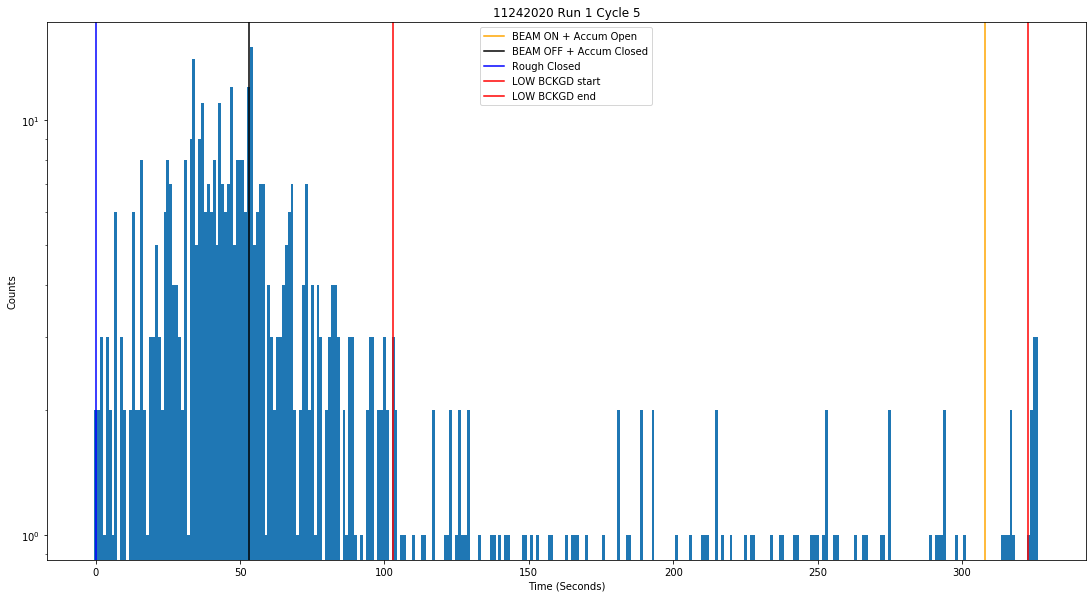

In [9]:
# How long until the background goes to a constant low rate? Use 11242020, Run = 1 

TimeInterval = (0,328)
Run_1 = Run(Date = '11242020', Run = 1)
Run_1.CycleSplit(TimeInterval)

df_Cumulative = pd.DataFrame().reindex_like(Run_1.Cycles[0][0])

BinNum = int(Run_1.Cycles[0][0]['TIMETAG'].max()*10**-12)


x = np.zeros((len(Run_1.Cycles[0]),BinNum+1))
y = np.zeros((len(Run_1.Cycles[0]),BinNum))


for i, df in enumerate(Run_1.Cycles[0]):
    
    y[i], x[i] = np.histogram(df['TIMETAG']*10**-12,bins=BinNum, range = [0,BinNum]);

    

ytot = np.sum(y, axis = 0)


# Plot summation of all cycles, or just one:

# plt.bar(x[0][:-1],ytot,width=1)
ax = plt.figure(figsize=(15,8))

plt.bar(x[0][:-1],y[5],width=1)


plt.tight_layout()
plt.title('11242020 Run 1 Cycle 5')
plt.ylabel('Counts')
plt.xlabel('Time (Seconds)')
plt.yscale('log')

plt.axvline(x=308, color = 'orange', label = 'BEAM ON + Accum Open') 
plt.axvline(x=53,color='black', label = 'BEAM OFF + Accum Closed') 
plt.axvline(x=0,color='blue', label = 'Rough Closed')
plt.axvline(x=103,color='red', label = 'LOW BCKGD start') 
plt.axvline(x=323,color='red', label = 'LOW BCKGD end')
 

plt.legend()
plt.show()

# Task 1, Item 4:

**Take-aways**

* It takes roughly 10s for the rate to begin to dimish once the beam is turned OFF. 
* It takes roughly 47s for the rate to reach its minimum once the beam is turned OFF. 
* It takes roughly 6s  for the rate to begin to climb once the beam is turned ON. 
* It takes roughly 24s for the rate to get to its maximum once the beam is turned ON. 


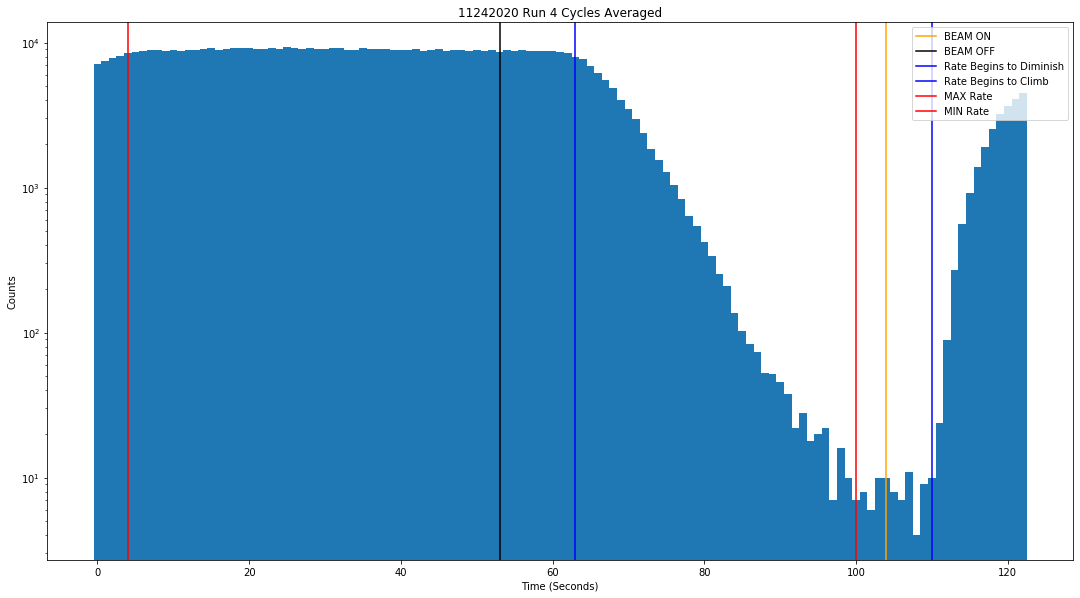

In [13]:
# How long until the background goes to a constant low rate? Use 11242020, Run = 1 

TimeInterval = (0,124)
Run_1 = Run(Date = '11242020', Run = 4)
Run_1.CycleSplit(TimeInterval)

df_Cumulative = pd.DataFrame().reindex_like(Run_1.Cycles[0][0])

BinNum = int(Run_1.Cycles[0][0]['TIMETAG'].max()*10**-12)


x = np.zeros((len(Run_1.Cycles[0]),BinNum+1))
y = np.zeros((len(Run_1.Cycles[0]),BinNum))


for i, df in enumerate(Run_1.Cycles[0]):
    
    y[i], x[i] = np.histogram(df['TIMETAG']*10**-12,bins=BinNum, range = [0,BinNum]);

    

ytot = np.sum(y, axis = 0)

# Plot just one cycle:

# plt.bar(x[0][:-1],y[5],width=1)
# plt.show()

# Plot summation of all cycles, or just one:


ax = plt.figure(figsize=(15,8))

plt.bar(x[0][:-1],ytot,width=1)
# plt.bar(x[0][:-1],ytot,width=1)

plt.tight_layout()
plt.title('11242020 Run 4 Cycles Averaged')
plt.ylabel('Counts')
plt.xlabel('Time (Seconds)')
plt.yscale('log')

plt.axvline(x=104, color = 'orange', label = 'BEAM ON') 
plt.axvline(x=53,color='black', label = 'BEAM OFF') 
plt.axvline(x=63,color='blue', label = 'Rate Begins to Diminish')
plt.axvline(x=110,color='blue', label = 'Rate Begins to Climb')
plt.axvline(x=4,color='red', label = 'MAX Rate ')
plt.axvline(x=100,color='red', label = 'MIN Rate') 

plt.legend()
plt.show()

# Investigating Flags 

6974     0x4080
11021    0x4080
11861    0x4080
17056    0x4080
20121    0x4080
Name: FLAGS, dtype: object 

Fraction of Events with Flag thrown in Run 0:  0.0014615982093442524 



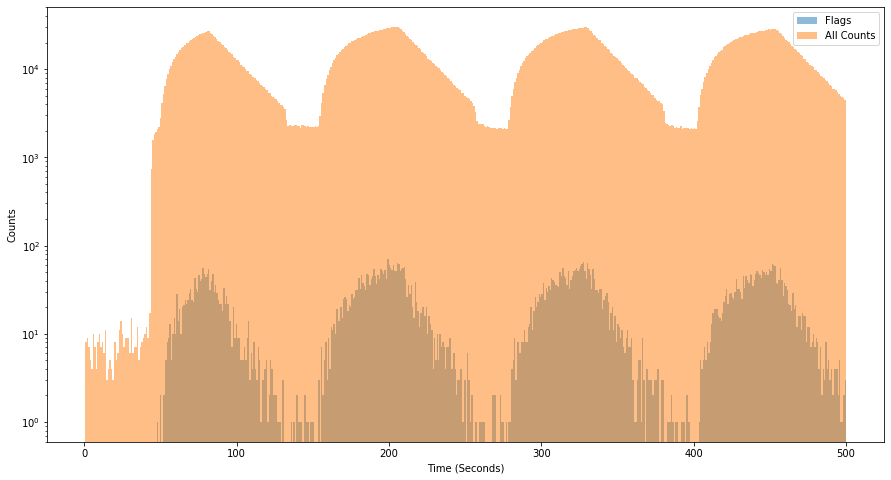

536     0x4080
1677    0x4080
2735    0x4080
2753    0x4080
2754    0x4080
Name: FLAGS, dtype: object 

Fraction of Events with Flag thrown in Run 1:  0.0017398028223468006 



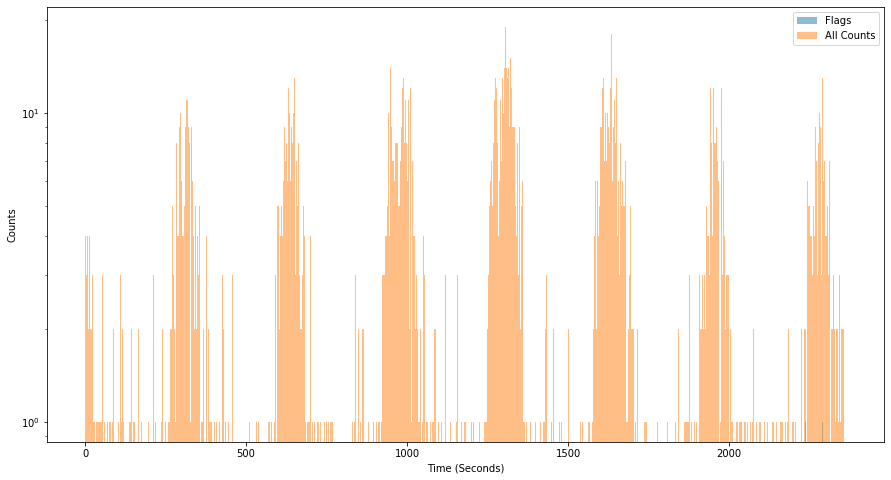

2445     0x4080
6158     0x4080
12328    0x4080
14609    0x4080
22299    0x4080
Name: FLAGS, dtype: object 

Fraction of Events with Flag thrown in Run 2:  0.0010540015324962675 



KeyboardInterrupt: 

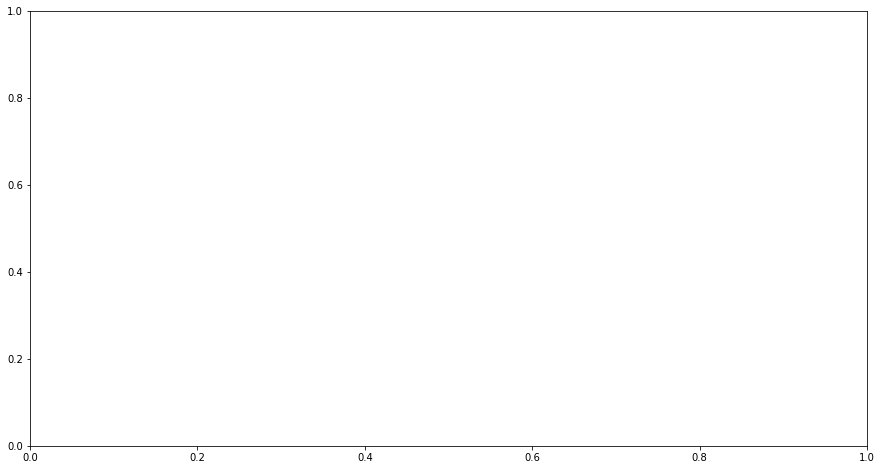

In [7]:
for i in range(9):
     
    Run_i = Run(Date = '11242020', Run = i)

    df = Run_i.Data[0][(Run_i.Data[0]['FLAGS']== '0x4080')]
    
    FracFlag = df.shape[0]/Run_i.Data[0].shape[0]
    print(df['FLAGS'][0:5], '\n')
    print('Fraction of Events with Flag thrown in Run {}: '.format(i), FracFlag ,'\n')
    
    BinNum = int(df['TIMETAG'].max()*10**-12) # Setting the number of bins = time of run in seconds. 
    plt.figure(figsize=(15,8))
    plt.tight_layout()
#     plt.title('09182020 Run {}'.format(i))
#     plt.ylabel('Counts')
#     plt.xlabel('Time (Seconds)')
#     plt.yscale('log')
#     y, x, _ = plt.hist(df['TIMETAG']*10**-12,bins=BinNum, range = [0,BinNum]);
    plt.hist(df['TIMETAG']*10**-12,bins=BinNum, alpha=.5, label='Flags')
    plt.hist(Run_i.Data[0]['TIMETAG']*10**-12,bins=BinNum, alpha=.5, label='All Counts')
    plt.legend(loc='upper right')
    plt.ylabel('Counts')
    plt.xlabel('Time (Seconds)')
    plt.yscale('log')
    plt.show()

## Investigating Energy of Flagged Events

**Take-aways** 

* The 0x4100 flag doesn't matter. 
* The 0x4080 flag corresponds to: 
    * The ENERGY is almost always 0 or exactly 1023 (occasionally it is just very small, ~1-3). The ENERGYSHORT is almost always 0 or 511 (very occasionally is it 1). However there are 0x4080 flagged events that have  ENERGY = 0 and 0x4080 flagged events that have ENERGYSHORT = 0 but none that have both = 0. So I don't really understand what ENERGY vs ENERGYSHORT is, in that I would have thought if ENERGY =0 then ENERGYSHORT must also be 0, but that is not the case here. **Either way we can just cut out events whose ENERGY + ENERGYSHORT > 500 because this is a much higher ADC channel than our normal events (~100 or less).**


In [5]:
for j in range(1):
     
    Run_j = Run(Date = '11242020', Run = j)
    for i in range(2):
        Flag = '0x4080'
        df = Run_j.Data[i][(Run_j.Data[i]['FLAGS']== Flag)]

        FracFlag = df.shape[0]/Run_j.Data[i].shape[0]
#         print(df['FLAGS'][0:5], '\n')
        print('Fraction of Events with Flag thrown in Run {}, Ch{}: '.format(j,i), FracFlag ,'\n')

#         BinNum = int(df['ENERGY'].max()) # Setting the number of bins = time of run in seconds. 
#         plt.figure(figsize=(15,8))
#         plt.tight_layout()
#         plt.hist(df['ENERGY'],bins=BinNum,range = [0,BinNum], alpha=.5, label='Flag:{}'.format(Flag))
#         plt.hist(Run_j.Data[i]['ENERGY'],bins=BinNum,range = [0,BinNum], alpha=.5, label='All Counts')
#         plt.title('Run 1, Ch{}'.format(i))
#         plt.legend(loc='upper right')
#         plt.ylabel('Counts')
#         plt.xlabel('ADC Channel')
#         plt.yscale('log')
# #         plt.xscale('log')
#         plt.show()
        
#         BinNum = int(df['ENERGYSHORT'].max()) # Setting the number of bins = time of run in seconds. 
#         plt.figure(figsize=(15,8))
#         plt.tight_layout()
#         plt.hist(df['ENERGYSHORT'],bins=BinNum,range = [0,BinNum], alpha=.5, label='Flag:{}'.format(Flag))
#         plt.hist(Run_j.Data[i]['ENERGYSHORT'],bins=BinNum,range = [0,BinNum], alpha=.5, label='All Counts')
#         plt.title('Run 1, Ch{}'.format(i))
#         plt.legend(loc='upper right')
#         plt.ylabel('Counts')
#         plt.xlabel('ADC Channel')
#         plt.yscale('log')
# #         plt.xscale('log')
#         plt.show()
        
        # Find the average EnergyShort/Energy
        EnergyAvg      = Run_j.Data[i]['ENERGY'].mean()
        EnergyShortAvg = Run_j.Data[i]['ENERGYSHORT'].mean()
#         EnergyAvgFlag      = df[(df['ENERGY']!= 0) & (df['ENERGY']!= 1023)]['ENERGY']
#         EnergyShortAvgFlag = df[(df['ENERGY'] == 0)]['ENERGYSHORT']
        
        EnergyAvgFlag      = df[(df['ENERGY']!= 0) & (df['ENERGY']!= 1023)]['ENERGY']
        EnergyShortAvgFlag = df[(df['ENERGY'] == 0)]['ENERGYSHORT']
        print('Ch{}'.format(i),'\n EnergyAvgFlag =', EnergyAvgFlag.shape,'\n EnergyShortAvgFlag =', EnergyShortAvgFlag[0:10])
        print(' \n Number of Flags thrown', df.shape)
#         EnergyAvg      = Run_j.Data[i]['ENERGY']
#         EnergyShortAvg = Run_j.Data[i]['ENERGYSHORT']
#         EnergyAvgFlag      = df['ENERGY']
#         EnergyShortAvgFlag = df['ENERGYSHORT']
# #         # Find the average EnergyShort/Energy
# #         EnergyAvg      = Run_j.Data[i]['ENERGY']/Run_j.Data[i]['ENERGYSHORT']
       
# #         EnergyAvgFlag      = df['ENERGY']/df['ENERGYSHORT']
       
        
#         print(EnergyAvgFlag[0:100], EnergyShortAvgFlag[0:100])
#         EnergyAvgFlag 
#         EnergyShortAvgFlag

Fraction of Events with Flag thrown in Run 0, Ch0:  0.0014615982093442524 

Ch0 
 EnergyAvgFlag = (457,) 
 EnergyShortAvgFlag = 6974     511
20121    511
28116    511
31887    511
38796    511
40602    511
47754    511
51288    511
58016    511
60892    511
Name: ENERGYSHORT, dtype: int64
 
 Number of Flags thrown (9230, 4)
Fraction of Events with Flag thrown in Run 0, Ch1:  0.006464286251554829 

Ch1 
 EnergyAvgFlag = (1914,) 
 EnergyShortAvgFlag = 20336    511
20382    511
25586    511
27205    511
28656    511
32501    511
39201    511
41997    511
43100    511
43817    511
Name: ENERGYSHORT, dtype: int64
 
 Number of Flags thrown (40822, 4)


In [23]:
Run_j = Run(Date = '11242020', Run = j)
Run_j.Data[0].keys

<bound method NDFrame.keys of                  TIMETAG  ENERGY  ENERGYSHORT   FLAGS
0           458996880243      15           14  0x4000
1           550049011997      19           18  0x4000
2           668588947997      19           18  0x4000
3           931750995997      36           35  0x4000
4           954621888242      18           18  0x4000
...                  ...     ...          ...     ...
6315000  500114187107996      86           84  0x4000
6315001  500114247859996      94           87  0x4000
6315002  500114406819999      24           24  0x4000
6315003  500114805859996      44           43  0x4000
6315004  500115404401794      67           64  0x4000

[6315005 rows x 4 columns]>

In [47]:
#  Working on the CountRate method:

def CountRate(Cycles, Data, BinSizeSeconds, TimeInterval): 
    
    # Bin size in units of 10**-12 s 
    BinSize = BinSizeSeconds*10**12
    
    # Open Ch's, Cycles: 
    CountRate = []
    for Ch in Cycles: 
        for CycleNum,Cycle in enumerate(Ch):
            

            CountRateTemp = np.histogram(CycleTemp)
            hist, bin_edges = np.histogram(a, density=True)
#             # Creating a temporary df for the events within the TimeInterval.
#             df0Temp = Data[0][(Data[0]['TIMETAG'] > Data[2]['TIMETAG'][i]+self.TimeInterval[0]*10**12) & (Data[0]['TIMETAG'] < Data[2]['TIMETAG'][i]+self.TimeInterval[1]*10**12)]
#             df1Temp = Data[1][(Data[1]['TIMETAG'] > Data[2]['TIMETAG'][i]+self.TimeInterval[0]*10**12) & (Data[1]['TIMETAG'] < Data[2]['TIMETAG'][i]+self.TimeInterval[1]*10**12)]
            
#             Ch0Cycles.extend([df0Temp])
#             Ch1Cycles.extend([df1Temp])

    




